In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np

#visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

#NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

#separo en validation y train
from sklearn.model_selection import train_test_split

#Encodear categorias
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

#Encodeo textos
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

#transformaciones
from sklearn.compose import ColumnTransformer

#Métricas (Errores)
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error

#Modelos
from sklearn.ensemble import RandomForestRegressor
#from sklearn.naive_bayes import MultinomialNB

#Optimización de hiperparmetros
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score


#Normalización
#from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
user_stories_train = pd.read_csv("/content/drive/My Drive/UserStories/train.csv")
user_stories_test = pd.read_csv("/content/drive/My Drive/UserStories/test.csv")

Se va usar el mismo pre-procesamiento en todos los modelos

# **Analisis exploratorio**

In [ ]:
user_stories_test.head()

,id,title,description,project
0,3433,Add Run > Tizen Emulator menu action in App an...,The action will create the launch shortcut for...,project8
1,106,Chrome & IE mis-behavior,"On Wed, Aug 4, 2010 at 12:21 PM, Bryan Beecher...",project2
2,7182,Problems with Publishing routes (on release re...,I have a problem with publishing routes in Nex...,project1
3,8985,Redis sink: better handling of module options/...,Please see the discussion here: https://githu...,project6
4,2149,java0.log generated by the SAM,"I found an issue on the TAC 5.2.1, a java0.log...",project1


In [ ]:
user_stories_train.head()

,id,title,description,project,storypoint
0,5660,Error enabling Appcelerator services during ap...,"When creating the default app, I encountered t...",project8,3
1,9014,Create a maintenance branch,"As a developer, I'd like to have a maintenance...",project6,5
2,4094,Service Activity Monitoring Backend integrated...,SAM API used by SAM GUI,project1,5
3,811,fs::enter(rootfs) does not work if 'rootfs' is...,I noticed this when I was testing the unified ...,project5,2
4,4459,transform processor with script option is broken,Creating the following stream throws exception...,project6,2


In [ ]:
user_stories_train.shape

(7900, 5)

In [ ]:
user_stories_test.shape

(1975, 4)

In [ ]:
user_stories_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7900 entries, 0 to 7899
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7900 non-null   int64 
 1   title        7900 non-null   object
 2   description  7900 non-null   object
 3   project      7900 non-null   object
 4   storypoint   7900 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 308.7+ KB


In [ ]:
user_stories_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1975 non-null   int64 
 1   title        1975 non-null   object
 2   description  1975 non-null   object
 3   project      1975 non-null   object
dtypes: int64(1), object(3)
memory usage: 61.8+ KB


In [ ]:
user_stories_train.duplicated().any()

False

In [ ]:
user_stories_test.duplicated().any()

False

In [ ]:
cantidad_nulos = user_stories_train.isnull().sum().reset_index().rename(columns = {0:'cantidad', 'index':'columnas'})
cantidad_nulos['porcentaje'] = (cantidad_nulos['cantidad'] / len(user_stories_train)) * 100
cantidad_nulos

,columnas,cantidad,porcentaje
0,id,0,0.0
1,title,0,0.0
2,description,0,0.0
3,project,0,0.0
4,storypoint,0,0.0


In [ ]:
cantidad_nulos = user_stories_test.isnull().sum().reset_index().rename(columns = {0:'cantidad', 'index':'columnas'})
cantidad_nulos['porcentaje'] = (cantidad_nulos['cantidad'] / len(user_stories_train)) * 100
cantidad_nulos

,columnas,cantidad,porcentaje
0,id,0,0.0
1,title,0,0.0
2,description,0,0.0
3,project,0,0.0


## **NLP**

Antes de entrenar, vamos a tokenizar y aplicar stopwords

In [6]:
#aplicamos NLP a la col description

# Preprocesa texto y devuelve un texto tokenizado

def procesadorDeTexto(comment):
    # Convierte a minúsculas
    comment = comment.lower()

    # Elimina signos de puntuación
    #comment = comment.translate(str.maketrans('', '', string.punctuation))
    comment = comment.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))

    # Tokeniza el texto
    tokens = word_tokenize(comment)

    # Elimina palabras vacías (stopwords) y tokens cortos
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

In [7]:
# Aplica la función de preprocesamiento a descripcion
user_stories_train['tokensDescription'] = user_stories_train['description'].apply(procesadorDeTexto)

# Convierto cada lista de tokens en una cadena de texto
user_stories_train['descriptionNLP'] = user_stories_train['tokensDescription'].apply(lambda tokens: ' '.join(tokens))

In [8]:
# Aplica la función de preprocesamiento a title
user_stories_train['tokensTitle'] = user_stories_train['title'].apply(procesadorDeTexto)

# Convierto cada lista de tokens en una cadena de texto
user_stories_train['titleNLP'] = user_stories_train['tokensTitle'].apply(lambda tokens: ' '.join(tokens))

In [9]:
# Aplica la función de preprocesamiento a descripcion
user_stories_test['tokensDescription'] = user_stories_test['description'].apply(procesadorDeTexto)

# Convierto cada lista de tokens en una cadena de texto
user_stories_test['descriptionNLP'] = user_stories_test['tokensDescription'].apply(lambda tokens: ' '.join(tokens))

In [10]:
# Aplica la función de preprocesamiento a title
user_stories_test['tokensTitle'] = user_stories_test['title'].apply(procesadorDeTexto)

# Convierto cada lista de tokens en una cadena de texto
user_stories_test['titleNLP'] = user_stories_test['tokensTitle'].apply(lambda tokens: ' '.join(tokens))

In [ ]:
user_stories_train.shape

(7900, 9)

In [ ]:
user_stories_test.shape

(1975, 8)

# **Visualizaciones**

# **Boxplot**

El proyecto 8 es el que tiene mayor complejidad

Text(0.5, 1.0, 'Proyectos de los storypoint')

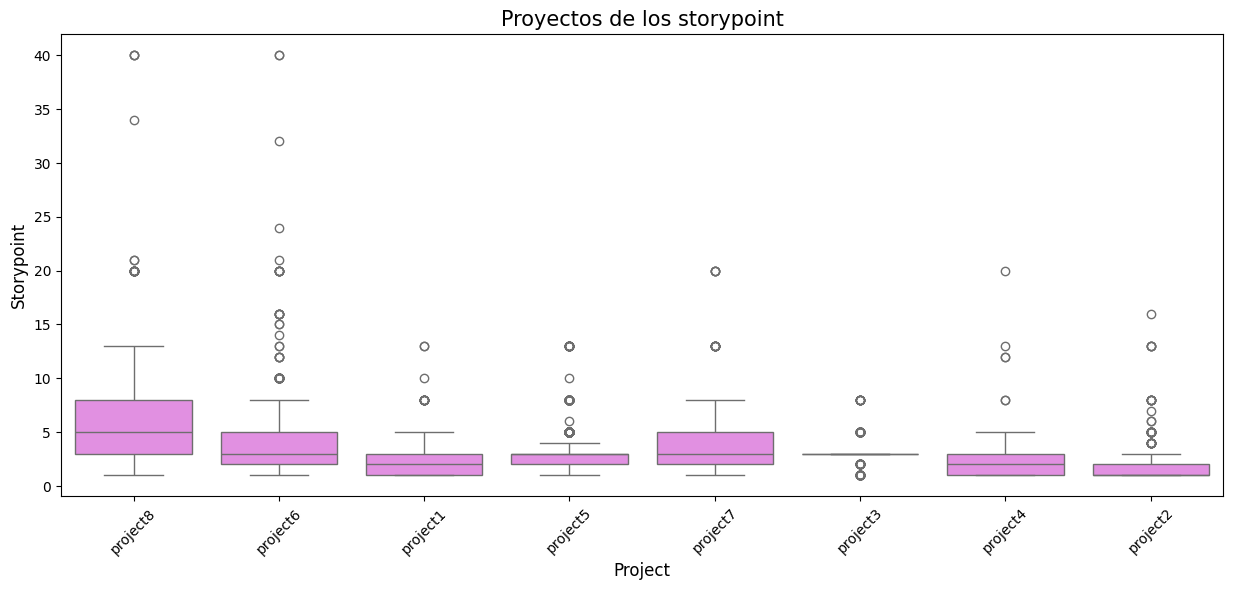

In [ ]:
project_storypoint = user_stories_train[['project','storypoint']]

plt.figure(figsize=(15,6))
sns.boxplot(data=project_storypoint, x="project", y="storypoint", color='violet')
plt.xticks(rotation=90)
plt.xlabel('Project', fontsize=12)
plt.ylabel('Storypoint', fontsize=12)
plt.xticks(rotation=45)
plt.title("Proyectos de los storypoint", fontsize=15)

# **Violin Plot**

Existe una mayor densidad de storypoints=21 y su promedio es el mas elevado a diferencia del resto.

In [11]:
user_stories_train['tittle_largo'] = user_stories_train['titleNLP'].apply(lambda x: len(x))
user_stories_train['description_largo'] = user_stories_train['descriptionNLP'].apply(lambda x: len(x))

In [12]:
user_stories_test['tittle_largo'] = user_stories_train['titleNLP'].apply(lambda x: len(x))
user_stories_test['description_largo'] = user_stories_train['descriptionNLP'].apply(lambda x: len(x))

<ipython-input-13-a3e6a36c651f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=user_stories_train, x='storypoint', y='tittle_largo', palette='BuPu')


Text(0, 0.5, 'Largo del Título')

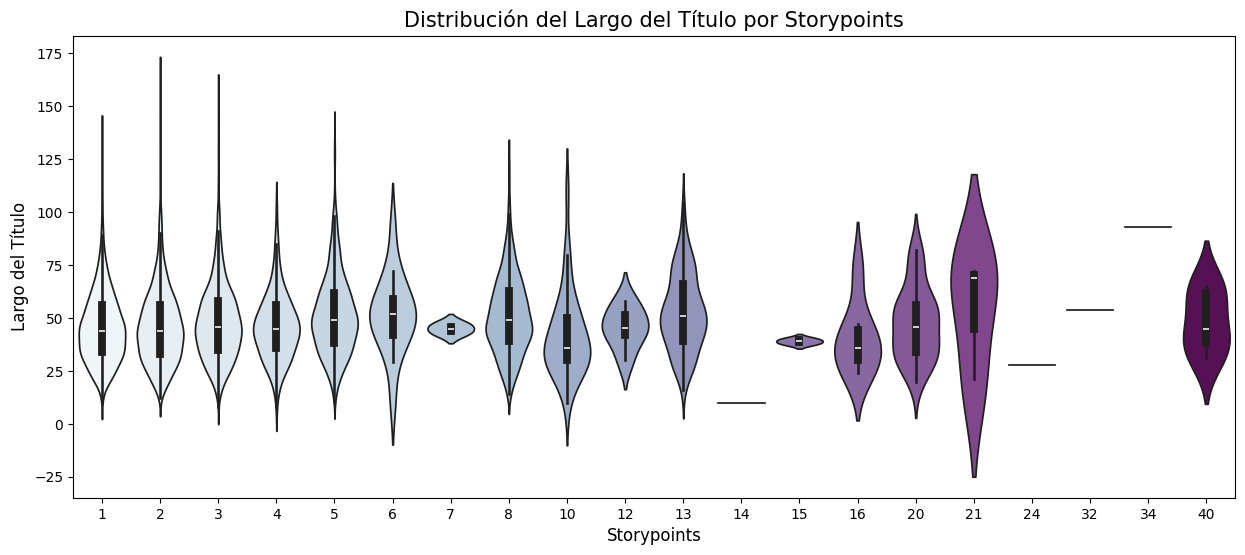

In [13]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=user_stories_train, x='storypoint', y='tittle_largo', palette='BuPu')
plt.title('Distribución del Largo del Título por Storypoints', fontsize=15)
plt.xlabel('Storypoints', fontsize=12)
plt.ylabel('Largo del Título', fontsize=12)

<ipython-input-14-cfcece582407>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=user_stories_train, x='storypoint', y='description_largo', palette='Blues')


Text(0, 0.5, 'Largo del Título')

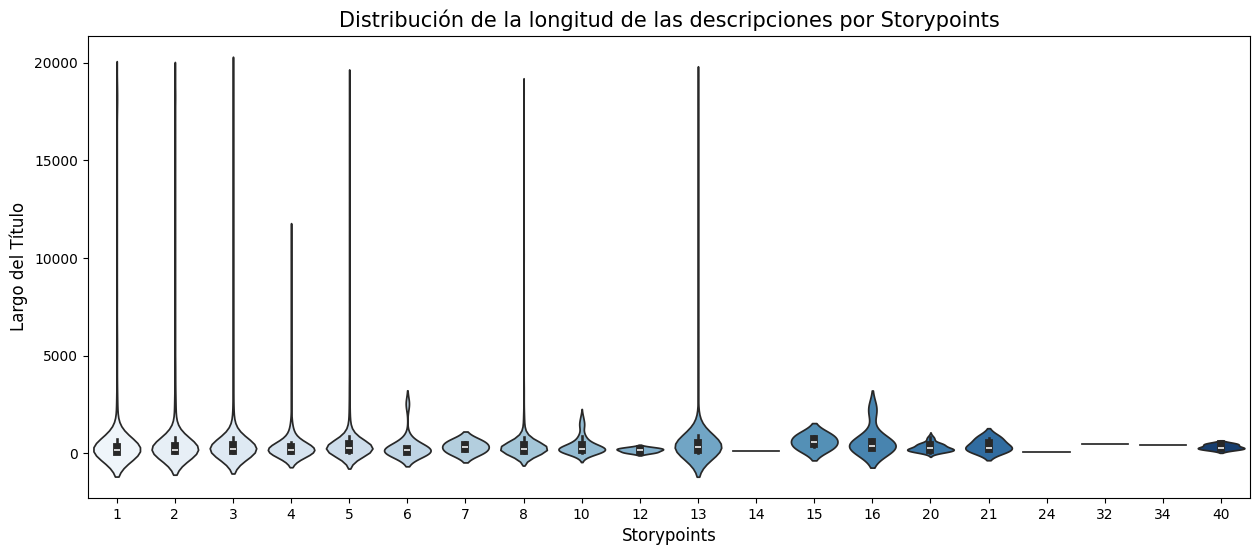

In [14]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=user_stories_train, x='storypoint', y='description_largo', palette='Blues')
plt.title('Distribución de la longitud de las descripciones por Storypoints', fontsize=15)
plt.xlabel('Storypoints', fontsize=12)
plt.ylabel('Largo del Título', fontsize=12)

## **Scatter Plot**

In [15]:
user_stories_train['title_token_cant'] = user_stories_train['tokensTitle'].apply(lambda x: len(x))
user_stories_train['description_token_cant'] = user_stories_train['tokensDescription'].apply(lambda x: len(x))

In [16]:
user_stories_test['title_token_cant'] = user_stories_test['tokensTitle'].apply(lambda x: len(x))
user_stories_test['description_token_cant'] = user_stories_test['tokensDescription'].apply(lambda x: len(x))

In [19]:
user_stories_train.shape, user_stories_test.shape

((7900, 13), (1975, 12))

Text(0, 0.5, 'Cantidad de token del Título')

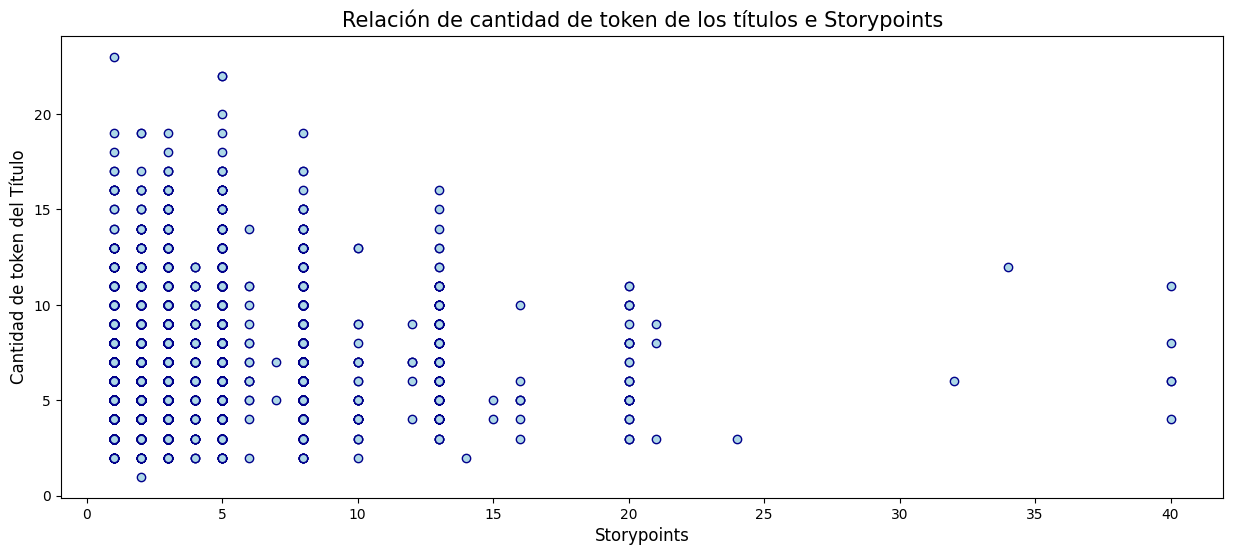

In [31]:
plt.figure(figsize=(15, 6))
plt.scatter(data=user_stories_train, x='storypoint', y='title_token_cant', c='#ADD8E6', edgecolors='#00008B')
plt.title('Relación de cantidad de token de los títulos e Storypoints', fontsize=15)
plt.xlabel('Storypoints', fontsize=12)
plt.ylabel('Cantidad de token del Título', fontsize=12)

Text(0, 0.5, 'Cantidad de token de description')

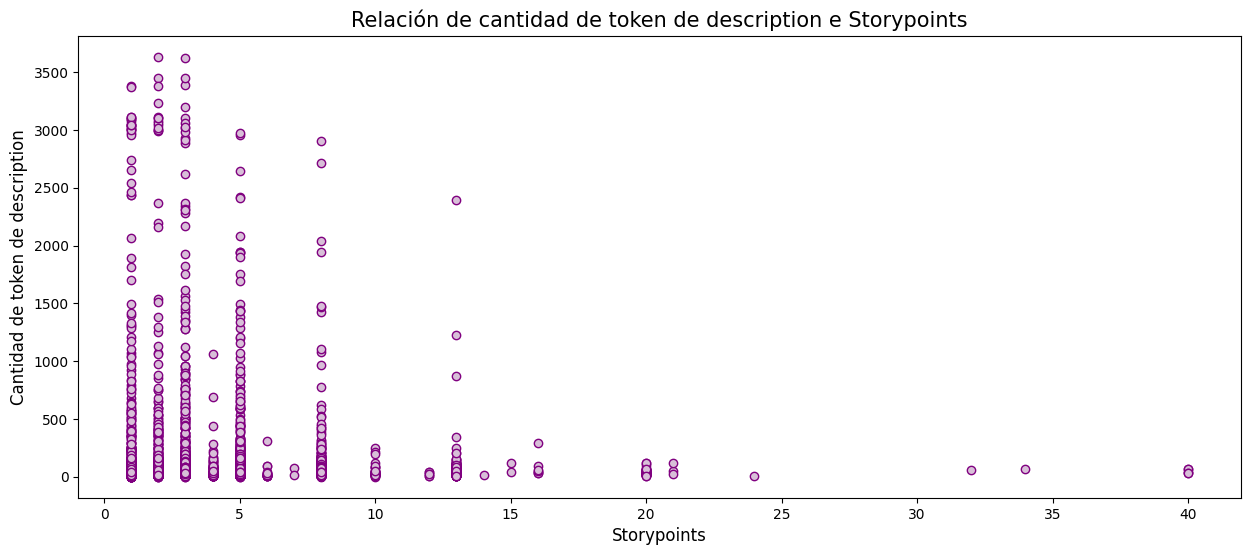

In [30]:
plt.figure(figsize=(15, 6))
plt.scatter(data=user_stories_train, x='storypoint', y='description_token_cant', c='#D8BFD8', edgecolors='#800080')
plt.title('Relación de cantidad de token de description e Storypoints', fontsize=15)
plt.xlabel('Storypoints', fontsize=12)
plt.ylabel('Cantidad de token de description', fontsize=12)

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(user['title_token_count'], df['storypoint'], alpha=0.6, edgecolors='k')
plt.title('Cantidad de Tokens del Título vs Storypoint', fontsize=14)
plt.xlabel('Cantidad de Tokens en el Título', fontsize=12)
plt.ylabel('Storypoint', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

(1975, 12)

# **Features**
Se ha creado los sgtes feature, en ambos dataset

*   title_largo
*   description_largo
*   title_token_cant
*   description_token_cant



# **División de datos**

## **Separando variable a predecir**

In [ ]:
user_stories_train.columns

Index(['id', 'title', 'description', 'project', 'storypoint',
       'tokensDescription', 'descriptionNLP', 'tokensTitle', 'titleNLP',
       'tittle_largo', 'description_largo', 'title_token_cant',
       'description_token_cant'],
      dtype='object')

In [ ]:
user_stories_test.columns

Index(['id', 'title', 'description', 'project', 'tokensDescription',
       'descriptionNLP', 'tokensTitle', 'titleNLP', 'tittle_largo',
       'description_largo', 'title_token_cant', 'description_token_cant'],
      dtype='object')

In [32]:
x = user_stories_train[['project','descriptionNLP','titleNLP','tittle_largo','description_largo','title_token_cant','description_token_cant']]
y = user_stories_train['storypoint']

In [33]:
x_test = user_stories_test[['project','descriptionNLP','titleNLP','tittle_largo','description_largo','title_token_cant','description_token_cant']]

## **Separo variable en train y validation**

Realizo un split 80% train y 20% validation con el fin de medir la performance de los distintos modelos con los que se va entrenar

In [34]:
x_train, x_validation, y_train, y_validation = train_test_split(x, y, train_size=0.8, random_state=42)

Saco los storypoint de validation que no están en train, ya que no puedo predecir valores que no se haya entrenado

In [ ]:
y_validation.unique()

array([ 1,  5, 10,  8,  2,  3, 14, 21, 13,  4, 20,  6, 12, 24])

In [ ]:
y_train.unique()

array([ 8,  5,  3,  1, 13,  2,  4,  6,  7, 10, 40, 16, 20, 34, 15, 32, 12,
       21])

 vemos que 14 y 24 no estan en el set de entrenamiento, por lo que cuando realice la prediccion esto va ser un problema, ya que estos datos no se entrenaron. Por lo que vamos a relizar un ajuste en estos datos de ambos set

In [ ]:
x_validation.head(13)

,project,descriptionNLP,titleNLP,tittle_largo,description_largo,title_token_cant,description_token_cant
4714,project1,current implementation routingslip deprecated ...,croutingslip component need update,34,95,4,12
533,project7,chart needs show complete history version incl...,patrick want understand progress towards versi...,62,760,8,108
6537,project6,update deployer class add following methods ru...,install xd admin instance ec2,29,618,5,91
1670,project6,developer like document performance benchmark ...,document performance benchmark results,38,153,4,19
5737,project4,stages configuration requires ux changes make ...,stage configuration ux update,29,218,4,32
3768,project5,add support user capabilities execute cli help...,add capabilities support mesos execute cli,42,97,6,12
5686,project5,add cmake build system docker build sh automat...,add cmake build docker build sh,31,91,6,14
733,project8,currently modules update button disabled since...,add update modules functionality,32,220,4,28
5385,project6,use single producer single consumer message si...,vary prefecth size ec db 3,26,294,6,48
239,project6,user wants restart failed job via cli e task r...,user wants restart failed job scd,33,69,6,13


In [ ]:
y_validation.head(13)

,storypoint
4714,1
533,5
6537,10
1670,8
5737,2
3768,3
5686,2
733,8
5385,3
239,8


In [35]:
#obtengo de train los valores unicos de storypoint
validos_storypoint = y_train.unique()

#filtro de y_validation todos los storypoint que se encuentran en train
estan_en_train = y_validation.isin(validos_storypoint)

#aplico a x_validation e y_validation los datos filtrados
x_validation = x_validation[estan_en_train]
y_validation = y_validation[estan_en_train]

In [ ]:
x_validation.head(13)

,project,descriptionNLP,titleNLP,tittle_largo,description_largo,title_token_cant,description_token_cant
4714,project1,current implementation routingslip deprecated ...,croutingslip component need update,34,95,4,12
533,project7,chart needs show complete history version incl...,patrick want understand progress towards versi...,62,760,8,108
6537,project6,update deployer class add following methods ru...,install xd admin instance ec2,29,618,5,91
1670,project6,developer like document performance benchmark ...,document performance benchmark results,38,153,4,19
5737,project4,stages configuration requires ux changes make ...,stage configuration ux update,29,218,4,32
3768,project5,add support user capabilities execute cli help...,add capabilities support mesos execute cli,42,97,6,12
5686,project5,add cmake build system docker build sh automat...,add cmake build docker build sh,31,91,6,14
733,project8,currently modules update button disabled since...,add update modules functionality,32,220,4,28
5385,project6,use single producer single consumer message si...,vary prefecth size ec db 3,26,294,6,48
239,project6,user wants restart failed job via cli e task r...,user wants restart failed job scd,33,69,6,13


In [ ]:
y_validation.head(13)

,storypoint
4714,1
533,5
6537,10
1670,8
5737,2
3768,3
5686,2
733,8
5385,3
239,8


In [ ]:
y_validation.unique()

array([ 1,  5, 10,  8,  2,  3, 21, 13,  4, 20,  6, 12])

## **Encoding**

**OneHotEncoding:** aplico a la columna project

In [36]:
x_train = x_train.reset_index().drop(["index"], axis=1)
x_validation = x_validation.reset_index().drop(["index"], axis=1)
x_test = x_test.reset_index().drop(["index"], axis=1)

In [37]:
def one_hot_encoding(x_train, x_validation, x_test, feature, **kwargs):
  one_hot_encoder = OneHotEncoder(**kwargs)

  encoded_feature_train = pd.DataFrame(one_hot_encoder.fit_transform(x_train[[feature]]).todense().astype(int))
  encoded_feature_valid = pd.DataFrame(one_hot_encoder.transform(x_validation[[feature]]).todense().astype(int))
  encoded_feature_test = pd.DataFrame(one_hot_encoder.transform(x_test[[feature]]).todense().astype(int))

  nombres_columnas = one_hot_encoder.get_feature_names_out()
  encoded_feature_train.columns = nombres_columnas
  encoded_feature_valid.columns = nombres_columnas
  encoded_feature_test.columns = nombres_columnas

  x_train = x_train.drop([feature], axis=1).join(pd.DataFrame(encoded_feature_train))
  x_validation = x_validation.drop([feature], axis=1).join(pd.DataFrame(encoded_feature_valid))
  x_test = x_test.drop([feature], axis=1).join(pd.DataFrame(encoded_feature_test))

  return x_train, x_validation, x_test

x_train, x_validation, x_test = one_hot_encoding(x_train, x_validation, x_test, 'project')

In [38]:
x_train.shape, x_validation.shape, x_test.shape

((6320, 14), (1578, 14), (1975, 14))

# **Entrenamientos**

# **Random Forest**

Se deja la configuracion de tfidf_description, tfidf_title, columns_transformer y pipeline para luego buscar los mejores hiperparametros con GridSearch y RandomSearch. Por ende el entrenamiento (1), se dejara como semilla de un modelo RandomForest para ver su predicción sin esa optimización de hiperparametros y todos los resultados tienen que ser mejor que ese modelo (1)

**1- Entrenamiento de Random Forest con hiperparámetros por default con TF-IDF**

Convertimos los textos en nros, usando TF-IDF

In [40]:
tfidf_description = ('description_tfidf', TfidfVectorizer(), 'descriptionNLP')
tfidf_title = ('title_tfidf', TfidfVectorizer(), 'titleNLP')

column_transformer = ColumnTransformer([tfidf_description, tfidf_title])

In [41]:
pipelineRF = Pipeline([
    ('tfidf', column_transformer),
    ('rf', RandomForestRegressor(random_state=2))
])

Entreno el modelo con pipeline

In [42]:
pipelineRF.fit(x_train, y_train)

Pipeline(steps=[('tfidf',
                 ColumnTransformer(transformers=[('description_tfidf',
                                                  TfidfVectorizer(),
                                                  'descriptionNLP'),
                                                 ('title_tfidf',
                                                  TfidfVectorizer(),
                                                  'titleNLP')])),
                ('rf', RandomForestRegressor(random_state=2))])

Predigo y evaluo el modelo a través de validation

In [ ]:
y_val_pred = pipelineRF.predict(x_validation)

In [ ]:
y_val_pred = pipelineRF.predict(x_validation)

mseRF = mean_squared_error(y_validation, y_val_pred)
maeRF = mean_absolute_error(y_validation, y_val_pred)
rmseRF = np.sqrt(mseRF)
RF_r2 = r2_score(y_validation, y_val_pred)

print("\nMétricas en el conjunto de validation:")
print('MSE (Validation):', mseRF)
print("MAE (Validation):", maeRF)
print('RMSE (Validation):', rmseRF)
print('R² Score (Validation):', RF_r2)


Métricas en el conjunto de validation:
MSE (Validation): 6.009691064638783
MAE (Validation): 1.6979911280101396
RMSE (Validation): 2.4514671249353484
R² Score (Validation): 0.2434054306561283


****2- Entrenamiento de Random Forest con TF-IDF y búsqueda de hiperparámetros con Random-Search y 3 folds****

In [193]:
hiperparametrosRF2 = {
    'rf__n_estimators': [20, 50, 100],
    'rf__max_depth': [None, 10, 20, 50],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 0.8]
}

# Configuración de RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipelineRF,
    param_distributions=hiperparametrosRF2,
    n_iter=10,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

Entrenar el modelo con validación cruzada

In [194]:
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf',
                                              ColumnTransformer(transformers=[('description_tfidf',
                                                                               TfidfVectorizer(),
                                                                               'descriptionNLP'),
                                                                              ('title_tfidf',
                                                                               TfidfVectorizer(),
                                                                               'titleNLP')])),
                                             ('rf',
                                              RandomForestRegressor(random_state=2))]),
                   n_jobs=-1,
                   param_distributions={'rf__max_depth': [None, 10, 20],
                                        'rf__max_features': ['sqrt', 0.8],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [20, 50, 100]},
                   random_state=42,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
                   verbose=2)

Mejores hiperparametros obtenidos con RandomSearch

In [196]:
print("Mejores hiperparámetros encontrados con RandomSearch:")
print(random_search.best_params_)
print("Mejor puntuación (negativo de MSE):", random_search.best_score_)

Mejores hiperparámetros encontrados con RandomSearch:
{'rf__n_estimators': 20, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_features': 0.8, 'rf__max_depth': None}
Mejor puntuación (negativo de MSE): -7.585611112518522


Predicción sobre x_validation con los mejores hiperparmetros encontrados

In [197]:
y_val_pred_rf_rs = random_search.best_estimator_.predict(x_validation)
mse_val = mean_squared_error(y_validation, y_val_pred_rf_rs)
print(f"Mean Squared Error (MSE) en validación: {mse_val}")

Mean Squared Error (MSE) en validación: 6.069755421097534


Predigo sobre el test y guardo los resultados en un csv

In [198]:
y_test_pred_rf_rs = random_search.best_estimator_.predict(x_test)

# genero el dataset id - storypoint:
submition = pd.DataFrame({'id': user_stories_test['id'], 'storypoint': y_test_pred_rf_rs})
print(submition.shape)
submition

(1975, 2)


,id,storypoint
0,3433,4.658669
1,106,2.346098
2,7182,2.631252
3,8985,3.967034
4,2149,2.146618
...,...,...
1970,9069,5.168711
1971,3100,2.612120
1972,6648,2.652210
1973,6076,5.980092


In [199]:
submition.to_csv('/content/drive/MyDrive/UserStories/randomForestNLPConTF_IDF_RandomSearch.csv', index=False)

**3- Ajusto los hiperparametros del modelo (2)**

In [43]:
hiperparametrosRF3 = {
    'rf__n_estimators': [50, 80, 100],
    'rf__max_depth': [10, 20, 30, 40],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 0.8]
}

# Configuración de RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipelineRF,
    param_distributions=hiperparametrosRF3,
    n_iter=10,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

Entrenar el modelo con validación cruzada

In [44]:
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf',
                                              ColumnTransformer(transformers=[('description_tfidf',
                                                                               TfidfVectorizer(),
                                                                               'descriptionNLP'),
                                                                              ('title_tfidf',
                                                                               TfidfVectorizer(),
                                                                               'titleNLP')])),
                                             ('rf',
                                              RandomForestRegressor(random_state=2))]),
                   n_jobs=-1,
                   param_distributions={'rf__max_depth': [10, 20, 30, 40],
                                        'rf__max_features': ['sqrt', 0.8],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [50, 80, 100]},
                   random_state=42,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
                   verbose=2)

Obtengo mejores hiperparametros y sus errores

In [45]:
# hiperparámetros
print(f'Mejor RMSE: {-random_search.best_score_}')
print(f'Mejores hiperparámetros: {random_search.best_params_}\n')

# errores de Train
y_pred_train = random_search.best_estimator_.predict(x_train)
rmse_train = mean_squared_error(y_train, y_pred_train)
print(f'RMSE en el conjunto de train: {rmse_train}\n')

# errores de Validation
y_pred_val = random_search.best_estimator_.predict(x_validation)
rmse_validation = mean_squared_error(y_validation, y_pred_val)
print(f'RMSE en el conjunto de prueba: {rmse_validation}')

Mejor RMSE: 7.660118552403115
Mejores hiperparámetros: {'rf__n_estimators': 50, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_features': 0.8, 'rf__max_depth': 40}

RMSE en el conjunto de train: 4.254580719385733

RMSE en el conjunto de prueba: 6.0476997254546525


In [46]:
y_test_pred_rf_rs = random_search.best_estimator_.predict(x_test)

# genero el dataset id - storypoint:
submition = pd.DataFrame({'id': user_stories_test['id'], 'storypoint': y_test_pred_rf_rs})
print(submition.shape)
submition

(1975, 2)


,id,storypoint
0,3433,5.345183
1,106,2.686501
2,7182,2.717474
3,8985,2.858959
4,2149,2.774781
...,...,...
1970,9069,4.822588
1971,3100,2.711195
1972,6648,2.945285
1973,6076,6.450526


In [47]:
submition.to_csv('/content/drive/MyDrive/UserStories/randomForestNLPConTF_IDF_RandomSearchAjustandoHiper.csv', index=False)

**4- Entrenamiento de Random Forest con TF-IDF y búsqueda de hiperparámetros con Grid-Search y 3 folds**

Búsqueda de los hiperparametros mediante GridSearch

In [48]:
# Búsqueda de hiperparámetros de Random Forest
hiperparametrosRF = {
    'rf__n_estimators': [50, 80, 100],
    'rf__max_depth': [None, 10, 20, 30, 50],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', 0.8]
}


grid_search = GridSearchCV(
    pipelineRF,
    hiperparametrosRF,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=3,
    verbose=2,
    n_jobs=-1
)

Entrena el modelo con validación cruzada

In [ ]:
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


Mejores hiperparametros obtenidos con GridSearch y obtención de errores

In [ ]:
# hiperparámetros
print(f'Mejor RMSE: {-random_search.best_score_}')
print(f'Mejores hiperparámetros encontrados con Grid-Search: {grid_search.best_params_}\n')
print("Mejor puntuación (negativo de MSE):", grid_search.best_score_)

# errores de Train
y_pred_train = random_search.best_estimator_.predict(x_train)
rmse_train = mean_squared_error(y_train, y_pred_train)
print(f'RMSE en el conjunto de train: {rmse_train}\n')

# errores de Validation
y_pred_val = random_search.best_estimator_.predict(x_validation)
rmse_validation = mean_squared_error(y_validation, y_pred_val)
print(f'RMSE en el conjunto de prueba: {rmse_validation}')

In [195]:
# print("Mejores hiperparámetros encontrados con GridSearch:")
# print(grid_search.best_params_)
# print("Mejor puntuación (negativo de MSE):", grid_search.best_score_)

Mejores hiperparámetros encontrados con GridSearch:


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

Predicción sobre x_validation con los mejores hiperparmetros encontrados

In [ ]:
# y_val_pred_rf_gs = grid_search.best_estimator_.predict(x_validation)
# mse = mean_squared_error(y_validation, y_val_pred_rf_gs)
# print('MSE con búsqueda Grid-Search (Validation):', mse)

Predigo sobre el test y guardo los resultados en un csv

In [ ]:
y_test_pred_rf_gs = grid_search.best_estimator_.predict(x_test)

# genero el dataset id - storypoint:
submition = pd.DataFrame({'id': user_stories_test['id'], 'storypoint': y_test_pred_rf_gs})
print(submition.shape)
submition

In [ ]:
submition.to_csv('/content/drive/MyDrive/UserStories/randomForestNLPConTF_IDF_GridSearch.csv', index=False)

**4- Entrenamiento de Random Forest con count vectorized y búsqueda de hiperparámetros con Random-Search y 3 folds**

Convertimos los textos en nros, usando Count vectorized

In [200]:
preprocessor = ColumnTransformer([
   ('title_countvect', CountVectorizer(max_features=1000, min_df=5, max_df=0.7), 'titleNLP'),  # Limitar vocabulario
   ('description_countvect', CountVectorizer(max_features=1000, min_df=5, max_df=0.7), 'descriptionNLP'),
])

# Pipeline con preprocesador y modelo RandomForestRegressor
pipelineRFCV = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

Defino los hiperparametros de Random Forest y se usará para optimizar Random Search

In [201]:
hiperparametrosRFCV = {
    'rf__n_estimators': [40, 80, 100],
    'rf__max_depth': [None, 20, 40, 80],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 0.8]
}

# Configuración de RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipelineRFCV,
    param_distributions=hiperparametrosRFCV,
    n_iter=10,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

Entreno el modelo

In [202]:
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('title_countvect',
                                                                               CountVectorizer(max_df=0.7,
                                                                                               max_features=1000,
                                                                                               min_df=5),
                                                                               'titleNLP'),
                                                                              ('description_countvect',
                                                                               CountVectorizer(max_df=0.7,
                                                                                               max_features=1000,
                                                                                               min_df=5),
                                                                               'descriptionNLP')])),
                                             ('rf',
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'rf__max_depth': [None, 20, 40, 80],
                                        'rf__max_features': ['sqrt', 0.8],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [40, 80, 100]},
                   random_state=42,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
                   verbose=2)

Mejores hiperparametros obtenidos con RandomSearch

In [203]:
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)
print("Mejor puntuación (negativo de MSE):", random_search.best_score_)

Mejores hiperparámetros encontrados:
{'rf__n_estimators': 40, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 2, 'rf__max_features': 'sqrt', 'rf__max_depth': None}
Mejor puntuación (negativo de MSE): -7.513438300668642


Predicción sobre x_validation con los mejores hiperparmetros encontrados

In [205]:
y_val_pred_rf_countvectorized_rs = random_search.best_estimator_.predict(x_validation)
mse_val = mean_squared_error(y_validation, y_val_pred)
print('MSE con búsqueda Random-Search (Validation):', mse_val)

MSE con búsqueda Random-Search (Validation): 6.009691064638783


Predigo sobre el test y guardo los resultados en un csv

In [206]:
y_test_pred_rf_countvectorized_rs = random_search.best_estimator_.predict(x_test)

# genero el dataset id - storypoint:
submition = pd.DataFrame({'id': user_stories_test['id'], 'storypoint': y_test_pred_rf_countvectorized_rs})
print(submition.shape)
submition

submition.to_csv('/content/drive/MyDrive/UserStories/randomForestNLPConCountVectorizedConRandomSearch.csv', index=False)

(1975, 2)


**5- Entrenamiento de Random Forest con count vectorized y búsqueda de hiperparámetros con Random-Search y 5 folds (Ajustando los hiperparametros del modelo 4)**

In [ ]:
hiperparametrosRFCV = {
    'rf__n_estimators': [40, 80, 100],
    'rf__max_depth': [None, 20, 40, 80],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 0.8]
}

# Configuración de RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipelineRFCV,
    param_distributions=hiperparametrosRFCV,
    n_iter=10,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)